import numpy as np

# -----------------------
# 0) Problem setup: pdf & domain
# -----------------------
# If you already have pdf(x) -> density on [0,1]^2, keep it.
def pdf(xy):
    # Example mixture. Replace with your true pdf.
    x, y = xy[:, 0], xy[:, 1]
    return (0.6*np.exp(-((x-0.30)**2 + (y-0.30)**2)/0.01) +
            0.4*np.exp(-((x-0.70)**2 + (y-0.70)**2)/0.02))

domain = np.array([[0.0, 1.0], [0.0, 1.0]])  # [0,1]^2
np.random.seed(42)

# -----------------------
# 1) Build Voronoi partition (centroids) by k-means on pdf samples
# -----------------------
def sample_from_pdf_2d(pdf_fn, n, dom=domain, rej_batch=20000, pdf_upper=None):
    """
    Rejection sampling on [0,1]^2 for demonstration. For production,
    switch to importance sampling or inverse CDF if available.
    """
    if pdf_upper is None:
        # Crude bound via grid; raise if your pdf can exceed this.
        grid = np.linspace(0, 1, 200)
        gx, gy = np.meshgrid(grid, grid)
        vals = pdf_fn(np.c_[gx.ravel(), gy.ravel()])
        pdf_upper = float(vals.max()) * 1.05
    out = []
    while len(out) < n:
        # propose uniform
        prop = np.random.rand(rej_batch, 2)
        u = np.random.rand(rej_batch) * pdf_upper
        keep = u < pdf_fn(prop)
        out.extend(prop[keep])
    return np.array(out[:n])

def kmeans_centroids(points, k, iters=50):
    """
    Minimal k-means (Lloyd) to avoid external deps.
    Returns centroids (k,2).
    """
    n = points.shape[0]
    # initialize by sampling points
    idx = np.random.choice(n, size=k, replace=False)
    C = points[idx].copy()
    for _ in range(iters):
        # assign
        d2 = ((points[:, None, :] - C[None, :, :])**2).sum(axis=2)
        lab = np.argmin(d2, axis=1)
        # update
        for j in range(k):
            mask = (lab == j)
            if np.any(mask):
                C[j] = points[mask].mean(axis=0)
            else:
                # reinitialize empty cluster
                C[j] = points[np.random.randint(n)]
    return C

# choose number of Voronoi cells
N = 64  # e.g. 64 cells
# draw pdf samples for k-means
samples = sample_from_pdf_2d(pdf, n=8000)
centroids = kmeans_centroids(samples, k=N, iters=60)  # (N,2)

# -----------------------
# 2) Estimate target_probs = μ(A_i) for Voronoi cells
# -----------------------
def estimate_voronoi_masses(pdf_fn, centroids, num_grid=800):
    gx = np.linspace(0.0, 1.0, num_grid)
    gy = np.linspace(0.0, 1.0, num_grid)
    dA = (gx[1]-gx[0]) * (gy[1]-gy[0])  # area per grid point

    Gx, Gy = np.meshgrid(gx, gy, indexing='xy')
    pts = np.c_[Gx.ravel(), Gy.ravel()]
    dens = pdf_fn(pts)  # (M,)
    # nearest centroid per grid point
    d2 = ((pts[:, None, :] - centroids[None, :, :])**2).sum(axis=2)
    nn = np.argmin(d2, axis=1)  # (M,)

    masses = np.zeros(len(centroids))
    # sum density * area for points assigned to each cell
    np.add.at(masses, nn, dens * dA)
    # normalize to sum=1 in case of numerical drift
    s = masses.sum()
    if s > 0:
        masses /= s
    return masses  # target_probs

target_probs = estimate_voronoi_masses(pdf, centroids, num_grid=800)  # (N,)

# -----------------------
# 3) Helpers: Voronoi queries & control direction
# -----------------------
def voronoi_index(x, centroids):
    """Return cell index i with nearest centroid to x."""
    d2 = ((centroids - x[None, :])**2).sum(axis=1)
    return int(np.argmin(d2))

def control_direction(xt, centroids, error_vec, sigma=0.2, eps=1e-12):
    """
    Your previous law but with Voronoi cells:
    vectors = c_i - x_t; weights gaussian in distance; inverse-distance push.
    error_vec e_i = max(mu(A_i) - lambda_g(A_i), 0).
    """
    V = centroids - xt[None, :]           # (N,2)
    d2 = (V**2).sum(axis=1) + eps         # (N,)
    w = np.exp(-d2 / (sigma**2))          # (N,)
    # sum_i e_i * w_i * (v_i / d2_i)
    dir_vec = (error_vec[:, None] * w[:, None] * (V / d2[:, None])).sum(axis=0)
    nrm = np.linalg.norm(dir_vec)
    if nrm < 1e-12:
        return np.zeros(2)
    return dir_vec / nrm

# -----------------------
# 4) Simulation loop (ergodic-ish matching on Voronoi cells)
# -----------------------
dt_emp = 0.01
Tsteps = 100001
dt = dt_emp
ud = 0.2

xt = np.array([0.5, 0.5], dtype=float)   # initial pos
x_traj = np.zeros((Tsteps, 2), dtype=float)
traj_counts = np.zeros(N, dtype=float)
metric_log = []

for t in range(Tsteps):
    # (a) update occupancy on current Voronoi cell
    cid = voronoi_index(xt, centroids)
    traj_counts[cid] += 1.0

    # (b) empirical occupancy over cells
    lam_g = traj_counts / (t+1.0)  # (N,)

    # (c) error vs target masses; only push for positive deficit
    e = np.maximum(0.0, target_probs - lam_g)  # (N,)

    # (d) compute control direction from centroids
    direction = control_direction(xt, centroids, e, sigma=0.2)
    ut = ud * direction

    # (e) forward Euler step + keep inside [0,1]^2
    xt = xt + dt * ut
    xt = np.clip(xt, 0.0, 1.0)
    x_traj[t] = xt

    # (f) simple squared-error metric
    metric_log.append(float(((target_probs - lam_g)**2).sum()))

    if (t % 10000 == 0) and (t != 0):
        print(f"Step {t}, pos={xt}, metric={metric_log[-1]:.6f}")

# Optional: if you have infomeasure installed & a target point cloud 'mu_samples',
# you can compute a kNN KLD between the trajectory points and mu-samples:
# import infomeasure as im
# KL = im.kullback_leiber_divergence(x_traj[:t,:], mu_samples[:t,:], approach='metric')
# print('KL (metric):', KL)

In [23]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl
import infomeasure as im

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [24]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension
# Discretize the search space into 100-by-100 mesh grids
num_grid = 256
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T

dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)
pdf_vals = pdf(grids)


In [25]:
def sample_from_pdf_2d(pdf, x_bounds, y_bounds, n_samples):
    samples = []
    xmin, xmax = x_bounds
    ymin, ymax = y_bounds
    
    # Find max of pdf in bounding box (or approximate)
    xs = np.linspace(xmin, xmax, 200)
    ys = np.linspace(ymin, ymax, 200)
    X, Y = np.meshgrid(xs, ys)
    Z = np.array([[pdf((x, y)) for x in xs] for y in ys])
    M = Z.max()  # Upper bound
    
    while len(samples) < n_samples:
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        u = np.random.uniform(0, M)
        if u < pdf(np.array((x, y))):   # accept
            samples.append([x, y])
    return np.array(samples)

In [26]:
from sklearn.cluster import KMeans
num_samples = 100_000
mu_samples = sample_from_pdf_2d(pdf, [0,1], [0,1], n_samples=num_samples)

In [ ]:
# --- Setup Voronoi partition from mu_samples ---
N = 16**2


kmeans = KMeans(n_clusters=N, random_state=42)
kmeans.fit(mu_samples)
centroids = kmeans.cluster_centers_

# Assign each mu_sample to nearest centroid to approximate target_probs
labels = kmeans.predict(mu_samples)
target_probs = np.zeros(N)
for i in range(N):
    target_probs[i] = np.mean(pdf(mu_samples[labels == i]))
# Normalize to get a probability distribution
target_probs /= np.sum(target_probs)

# --- Dynamics & simulation ---
# Plot
plt.figure(figsize=(8,8))
plt.scatter(mu_samples[:,0], mu_samples[:,1], c=labels, cmap='tab20', s=10, alpha=0.6)
plt.scatter(centroids[:,0], centroids[:,1], c='black', marker='x', s=100, label='centroids')
plt.title(f'{N} Voronoi cells approximating PDF')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

c:\Users\JP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Step 10000, pos=[0.7629 0.2134], metric=0.00026
Step 20000, pos=[0.2804 0.3524], metric=0.00009
Step 30000, pos=[0.2913 0.3192], metric=0.00005
Step 40000, pos=[0.5124 0.6058], metric=0.00003
Step 50000, pos=[0.2175 0.3549], metric=0.00002
Step 60000, pos=[0.4016 0.3628], metric=0.00001
Step 70000, pos=[0.5204 0.5301], metric=0.00001
Step 80000, pos=[0.2966 0.2666], metric=0.00001
Step 90000, pos=[0.4381 0.4111], metric=0.00001
Step 100000, pos=[0.4013 0.6564], metric=0.00001


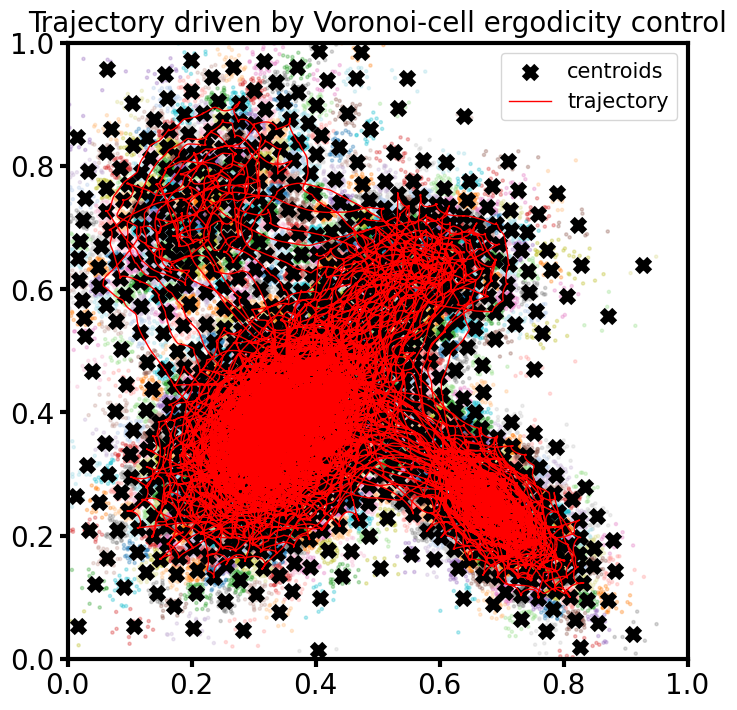

In [ ]:
dt_emp = 0.01
tsteps = 100001
dt = dt_emp
ud = 0.2

def step(xt, ut):
    return xt + dt * ut

# Initialize
xt = np.array([0.5, 0.5])
x_traj = np.zeros((tsteps, 2))
traj_counts = np.zeros(N)
metric_log = []

for t in range(tsteps):
    # 1. Assign xt to nearest Voronoi centroid
    dists = np.linalg.norm(centroids - xt, axis=1)
    cell_idx = np.argmin(dists)
    traj_counts[cell_idx] += 1

    # 2. Empirical distribution
    lambda_g = traj_counts / (t+1)

    # 3. Control direction based on errors
    e = target_probs - lambda_g
    e = np.maximum(0, e)
    sigma = 0.2
    epsilon = 1e-12
    vectors = centroids - xt
    dist2 = np.sum(vectors**2, axis=1) + epsilon
    weights = np.exp(-dist2 / sigma**2)
    direction = np.sum(e[:, None] * weights[:, None] * (vectors / dist2[:, None]), axis=0)
    ut = ud * direction / (np.linalg.norm(direction) + 1e-8)

    # 4. Step dynamics
    xt = step(xt, ut)
    x_traj[t] = xt.copy()

    # 5. Metric
    metric = np.sum((target_probs - lambda_g)**2)
    metric_log.append(metric)

    if t % 10000 == 0 and t != 0:
        print(f"Step {t}, pos={xt}, metric={metric:.5f}")

# --- Visualization ---
plt.figure(figsize=(8,8))
plt.scatter(mu_samples[:,0], mu_samples[:,1], c=labels, cmap="tab20", s=5, alpha=0.3)
plt.scatter(centroids[:,0], centroids[:,1], c="black", marker="x", s=80, label="centroids")
plt.plot(x_traj[:,0], x_traj[:,1], c="red", linewidth=1, label="trajectory")
plt.legend()
plt.title("Trajectory driven by Voronoi-cell ergodicity control")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()


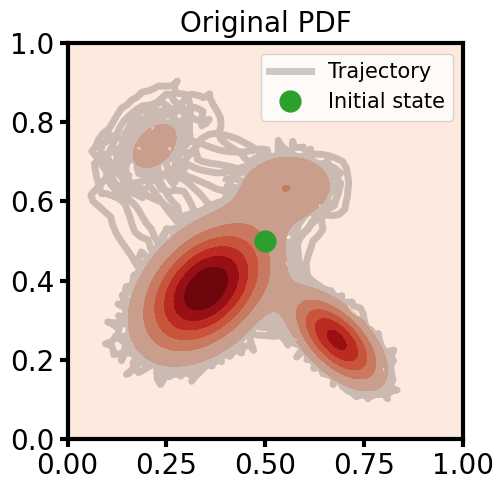

In [29]:
fig, ax = plt.subplots(figsize=(6, 5), dpi=100, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
#ax.contourf(GX, GY, vals.reshape(ng, ng), cmap='Reds', alpha=0.6)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', alpha=1.)
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

plt.show()
plt.close()

In [ ]:
im.kld(x_traj[:t,:],mu_samples[:t,:], approach='metric')

0.47412650215326746